This notebook contains BDT variables' distribution for signals of representative parameter points. **Triggered events only**.

Electron type and muon type leptonJets' distributions are plotted separately. **Matched only**.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.trigger import Triggers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))
scale2mu2e_ = json.load(open('../Samples/signal_2mu2e_scale.json'))

In [3]:
dataset={
    '2mu2e/mXX-100_mA-5_lxy-300': dict(files=dataset2mu2e_['mXX-100_mA-5_lxy-300'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dict(files=dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'], treename='ffNtuplizer/ffNtuple'),
}

lumi = 60.432
scales={}
for k in scale2mu2e_:
    scales[f'2mu2e/{k}'] = lumi * scale2mu2e_[k]

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [4]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal datasets')
        type_axis    = hist.Cat('typed', 'leptonJet type')
        pt0_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 200) # small range
        pt1_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 750) # large range
        
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        mass_axis     = hist.Bin("mass", "mass [GeV]", 50, 0, 20)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 750)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 2000)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 1000)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt0': hist.Hist("#counts/4GeV", dataset_axis, pt0_axis, type_axis),
            'pt1': hist.Hist("#counts/15GeV", dataset_axis, pt1_axis, type_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis, type_axis),
            "mass": hist.Hist("#counts/0.4GeV", dataset_axis, mass_axis, type_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis, type_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis, type_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis, type_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis, type_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis, type_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis, type_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis, type_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis, type_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis, type_axis),
            "ecfe1": hist.Hist("#counts/15", dataset_axis, ecfe1_axis, type_axis),
            "ecfe2": hist.Hist("#counts/40", dataset_axis, ecfe2_axis, type_axis),
            "ecfe3": hist.Hist("#counts/20", dataset_axis, ecfe3_axis, type_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, type_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
            nef=((df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT']).content,
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'].content,
            pfiso=df['pfjet_pfIsolation05'].content,
            spreadpt=df['pfjet_ptDistribution'].content,
            spreaddr=df['pfjet_dRSpread'].content,
            lamb=df['pfjet_subjet_lambda'].content,
            epsi=df['pfjet_subjet_epsilon'].content,
            ecf1=df['pfjet_subjet_ecf1'].content,
            ecf2=df['pfjet_subjet_ecf2'].content,
            ecf3=df['pfjet_subjet_ecf3'].content,
            mva=df['pfjet_mva'].content,
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content
        )
        darkphotons = genparticles[genparticles.pid==32]
        dp_el = darkphotons[df['gen2_pid']==11]
        dp_mu = darkphotons[df['gen2_pid']==13]
        matchmask_el = leptonjets.match(dp_el, deltaRCut=0.3)
        matchmask_mu = leptonjets.match(dp_mu, deltaRCut=0.3)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        leptonjets_el = leptonjets[matchmask_el][metfiltermask&triggermask]
        leptonjets_mu = leptonjets[matchmask_mu][metfiltermask&triggermask]
        
        output['pt0']     .fill(dataset=dataset, typed='electron type', pt=leptonjets_el.p4.pt.flatten())
        output['pt1']     .fill(dataset=dataset, typed='electron type', pt=leptonjets_el.p4.pt.flatten())
        output['eta']     .fill(dataset=dataset, typed='electron type', eta=leptonjets_el.p4.eta.flatten())
        output['mass']    .fill(dataset=dataset, typed='electron type', mass=leptonjets_el.p4.mass.flatten())
        output['nef']     .fill(dataset=dataset, typed='electron type', nef=leptonjets_el.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, typed='electron type', maxd0=leptonjets_el.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, typed='electron type', mind0=leptonjets_el.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, typed='electron type', tkiso=leptonjets_el.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, typed='electron type', pfiso=leptonjets_el.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, typed='electron type', spreadpt=leptonjets_el.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, typed='electron type', spreaddr=leptonjets_el.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, typed='electron type', lamb=leptonjets_el.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, typed='electron type', epsi=leptonjets_el.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, typed='electron type', ecfe1=leptonjets_el.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, typed='electron type', ecfe2=leptonjets_el.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, typed='electron type', ecfe3=leptonjets_el.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, typed='electron type', mva=leptonjets_el.mva.flatten())
        
        output['pt0']     .fill(dataset=dataset, typed='muon type', pt=leptonjets_mu.p4.pt.flatten())
        output['pt1']     .fill(dataset=dataset, typed='muon type', pt=leptonjets_mu.p4.pt.flatten())
        output['eta']     .fill(dataset=dataset, typed='muon type', eta=leptonjets_mu.p4.eta.flatten())
        output['mass']    .fill(dataset=dataset, typed='muon type', mass=leptonjets_mu.p4.mass.flatten())
        output['nef']     .fill(dataset=dataset, typed='muon type', nef=leptonjets_mu.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, typed='muon type', maxd0=leptonjets_mu.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, typed='muon type', mind0=leptonjets_mu.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, typed='muon type', tkiso=leptonjets_mu.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, typed='muon type', pfiso=leptonjets_mu.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, typed='muon type', spreadpt=leptonjets_mu.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, typed='muon type', spreaddr=leptonjets_mu.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, typed='muon type', lamb=leptonjets_mu.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, typed='muon type', epsi=leptonjets_mu.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, typed='muon type', ecfe1=leptonjets_mu.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, typed='muon type', ecfe2=leptonjets_mu.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, typed='muon type', ecfe3=leptonjets_mu.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, typed='muon type', mva=leptonjets_mu.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        for k in accumulator:
            accumulator[k].scale(scales, axis='dataset')
        return accumulator

In [5]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12,),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 10/10 [00:04<00:00,  1.10s/items]


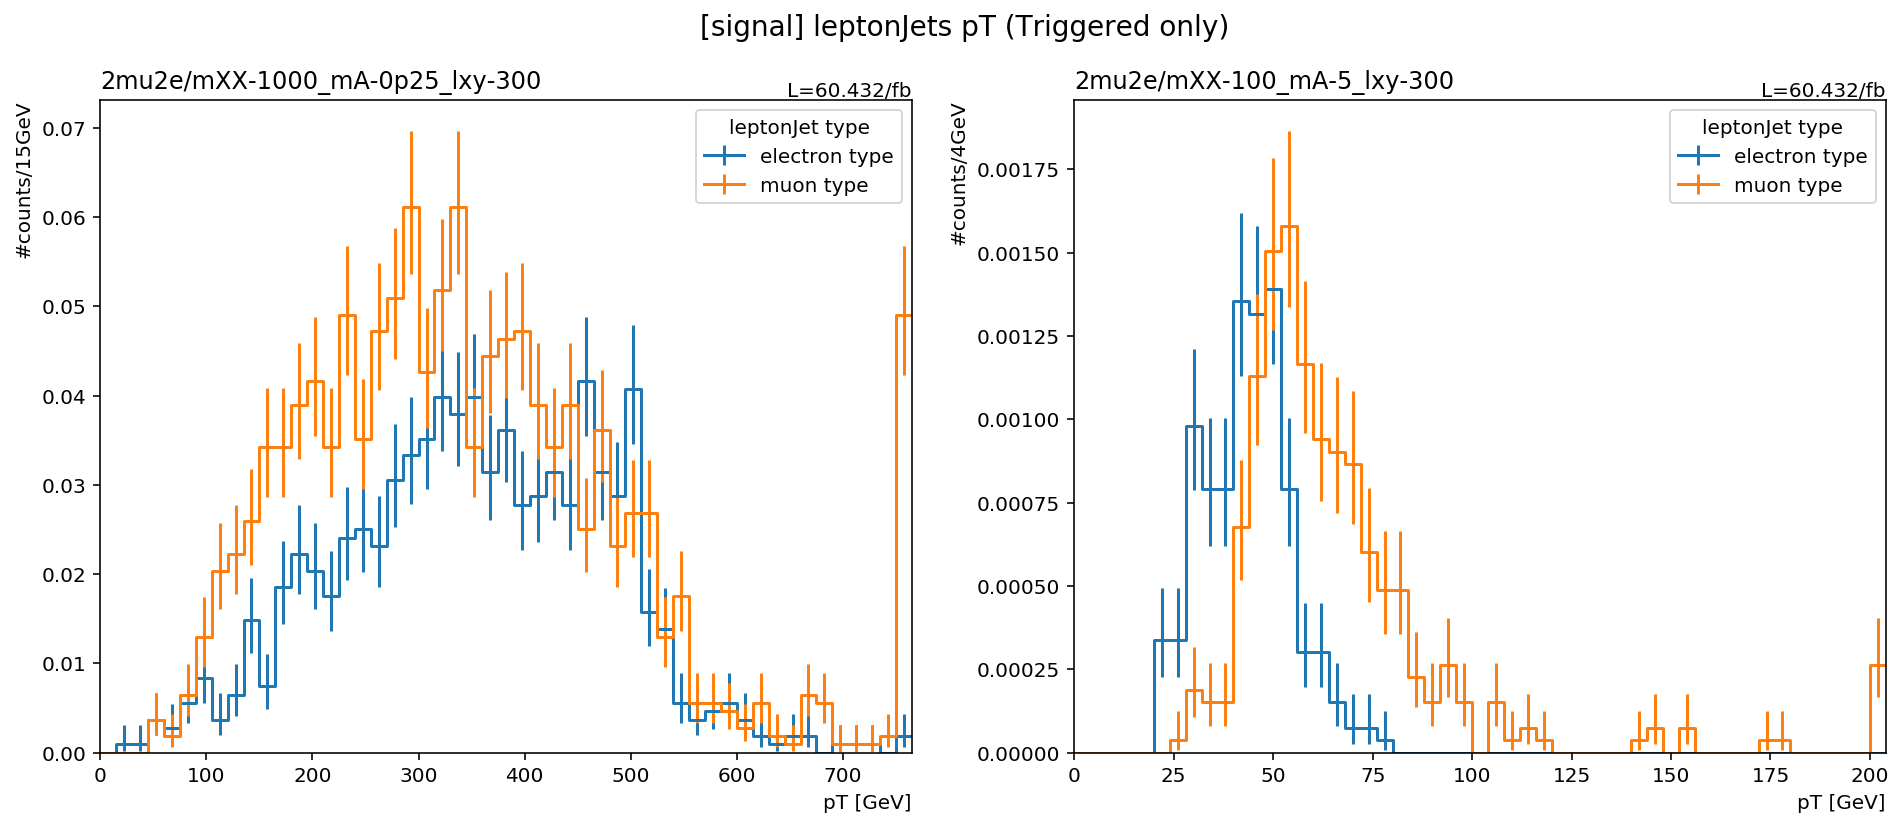

In [6]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['pt1']['2mu2e/mXX-1000_mA-0p25_lxy-300'].project('dataset'), overlay='typed', ax=axes[0], density=False, overflow='over')
hist.plot1d(output['pt0']['2mu2e/mXX-100_mA-5_lxy-300'].project('dataset'), overlay='typed', ax=axes[1], density=False, overflow='over')

axes[0].set_title('2mu2e/mXX-1000_mA-0p25_lxy-300')
axes[1].set_title('2mu2e/mXX-100_mA-5_lxy-300')
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
plt.suptitle('[signal] leptonJets pT (Triggered only)', fontsize=14);

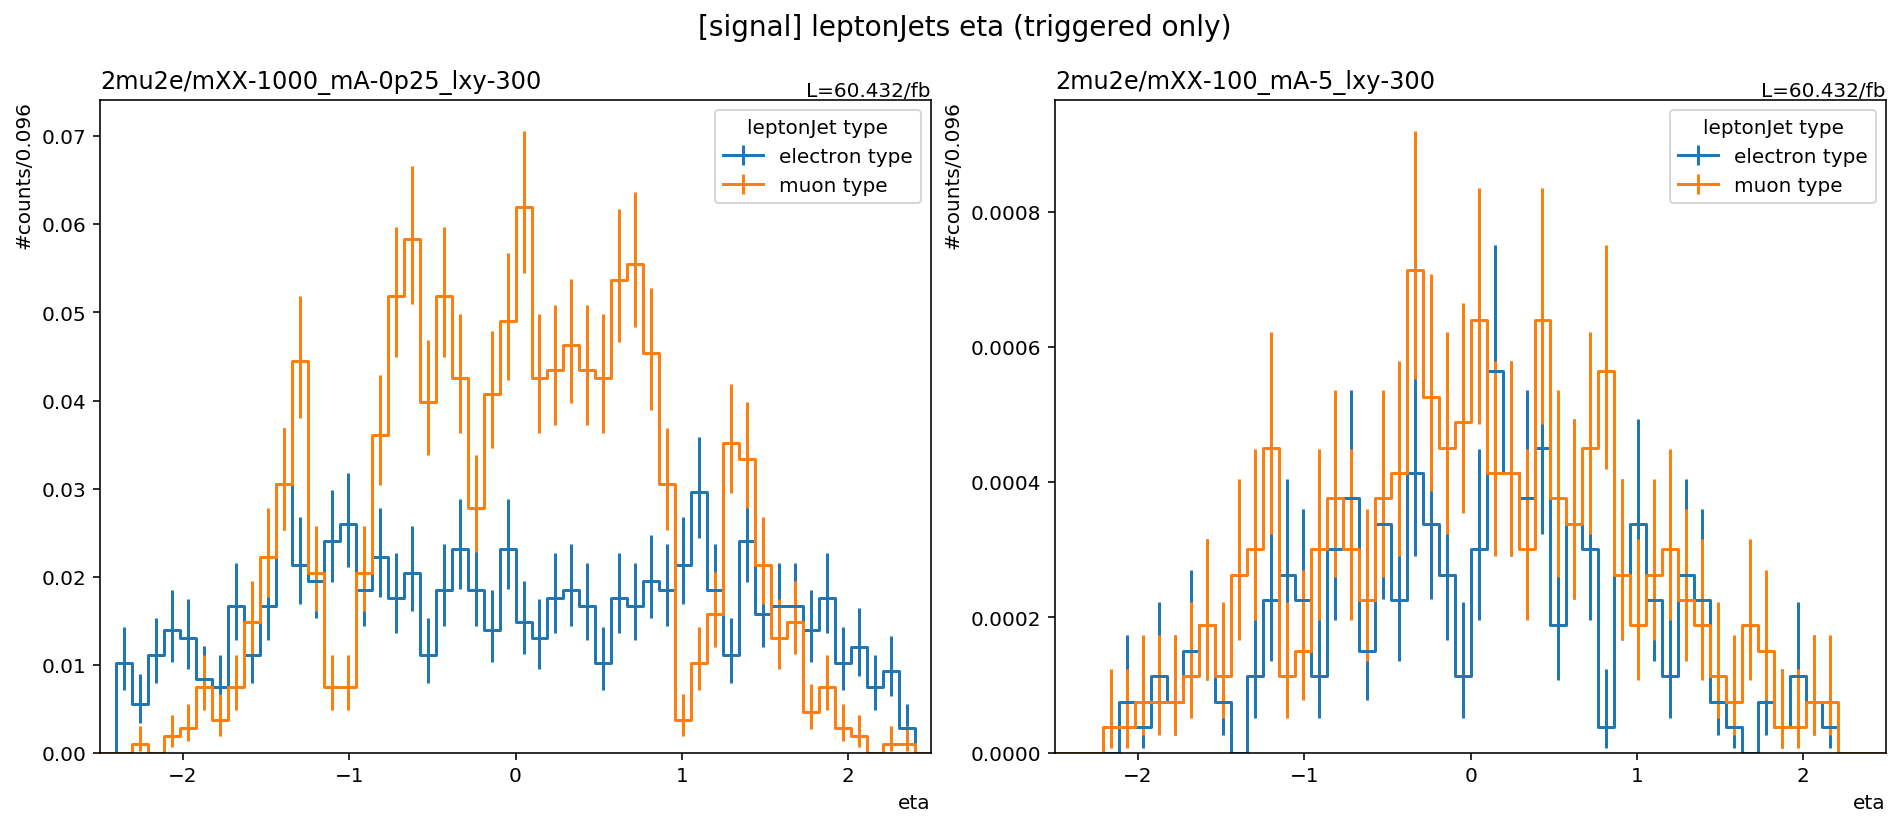

In [7]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['eta'], figure=fig, col='dataset', overlay='typed', overflow='all', density=False)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
plt.suptitle('[signal] leptonJets eta (triggered only)', fontsize=14);

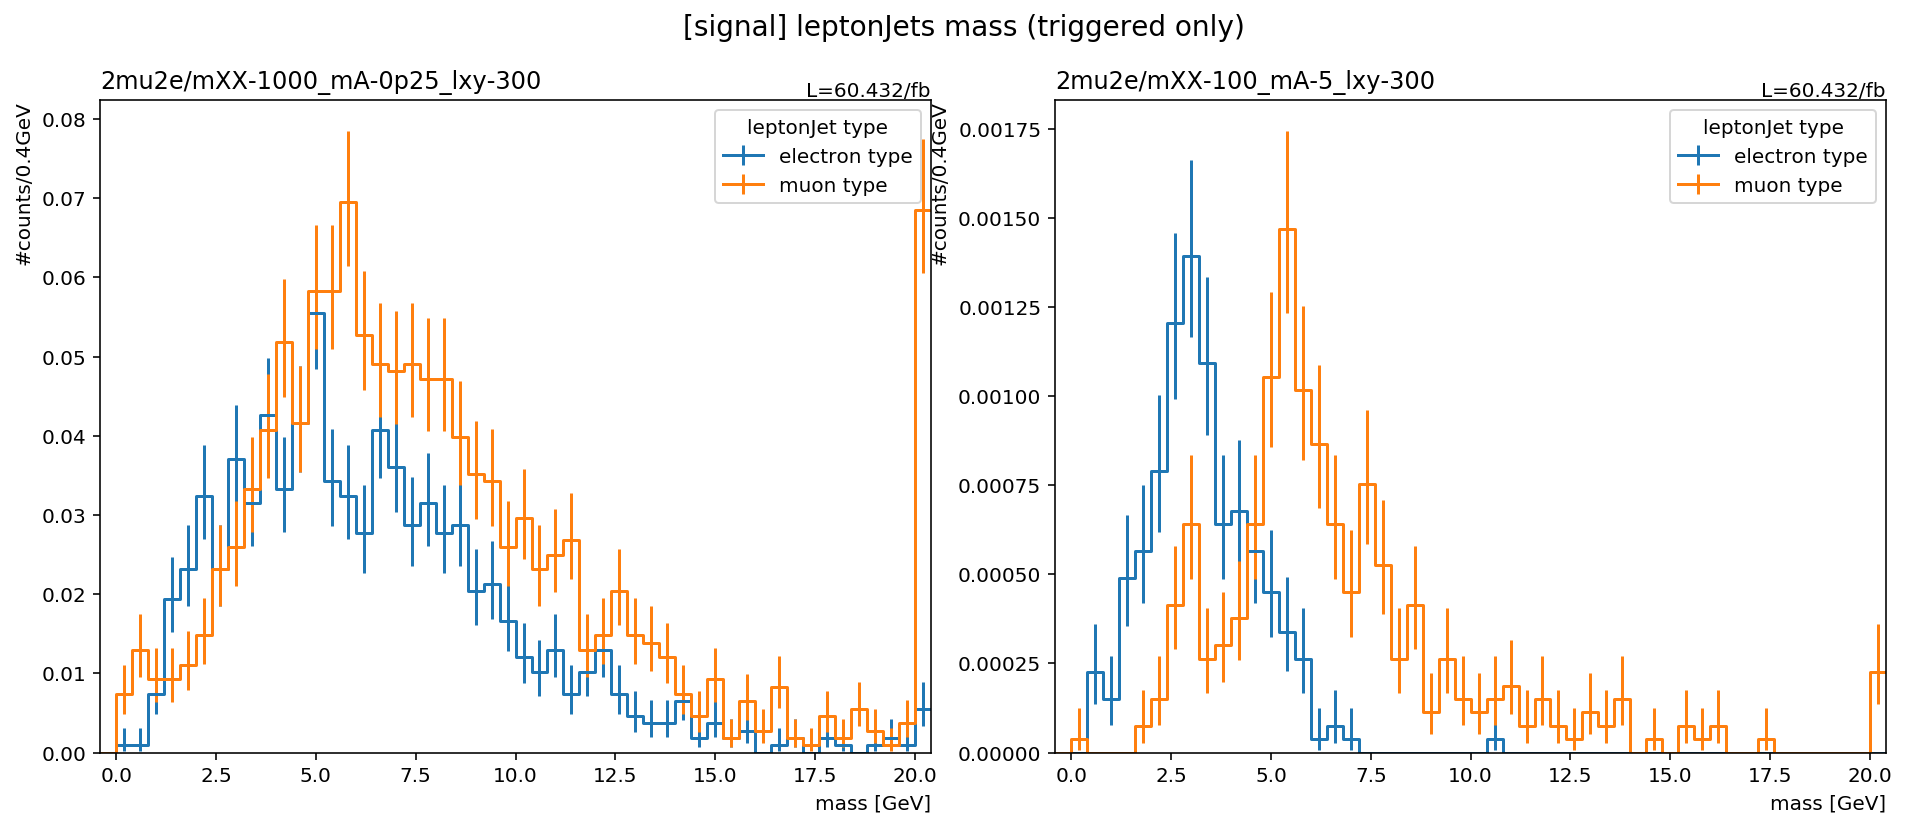

In [8]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15},)
fig, axes = hist.plotgrid(output['mass'], figure=fig, col='dataset', overlay='typed', overflow='all', density=False)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
plt.suptitle('[signal] leptonJets mass (triggered only)', fontsize=14);

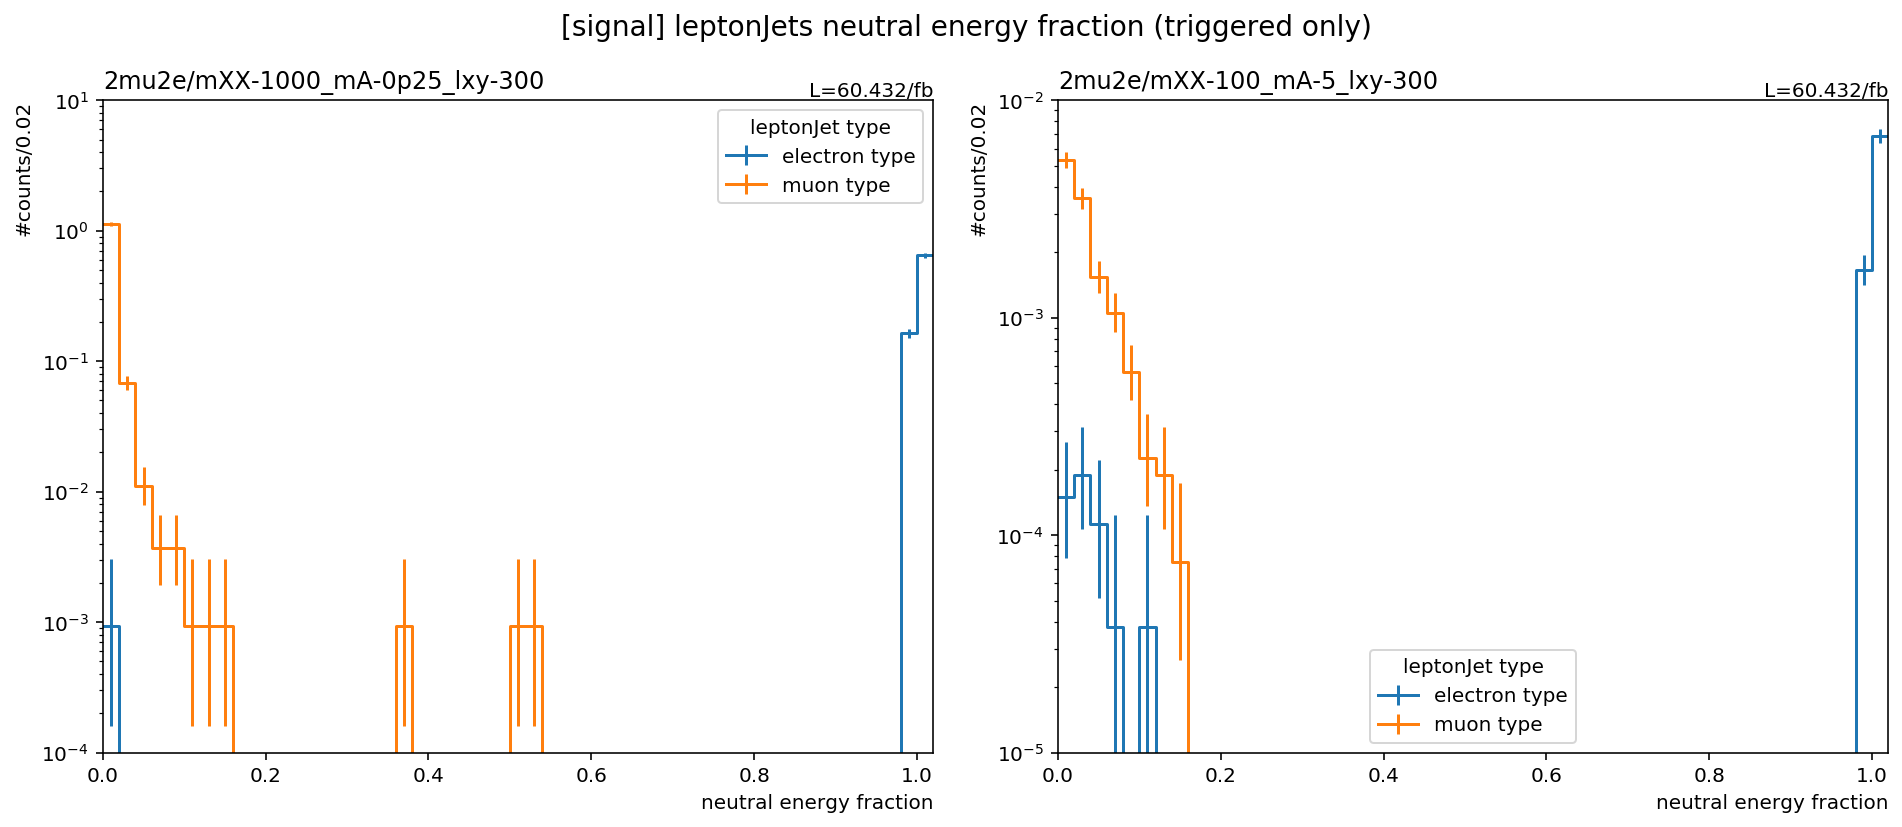

In [9]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['nef'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
axes[0,0].set_ylim([1e-4, 1e1])
axes[0,1].set_ylim([1e-5, 1e-2])
plt.suptitle('[signal] leptonJets neutral energy fraction (triggered only)', fontsize=14);

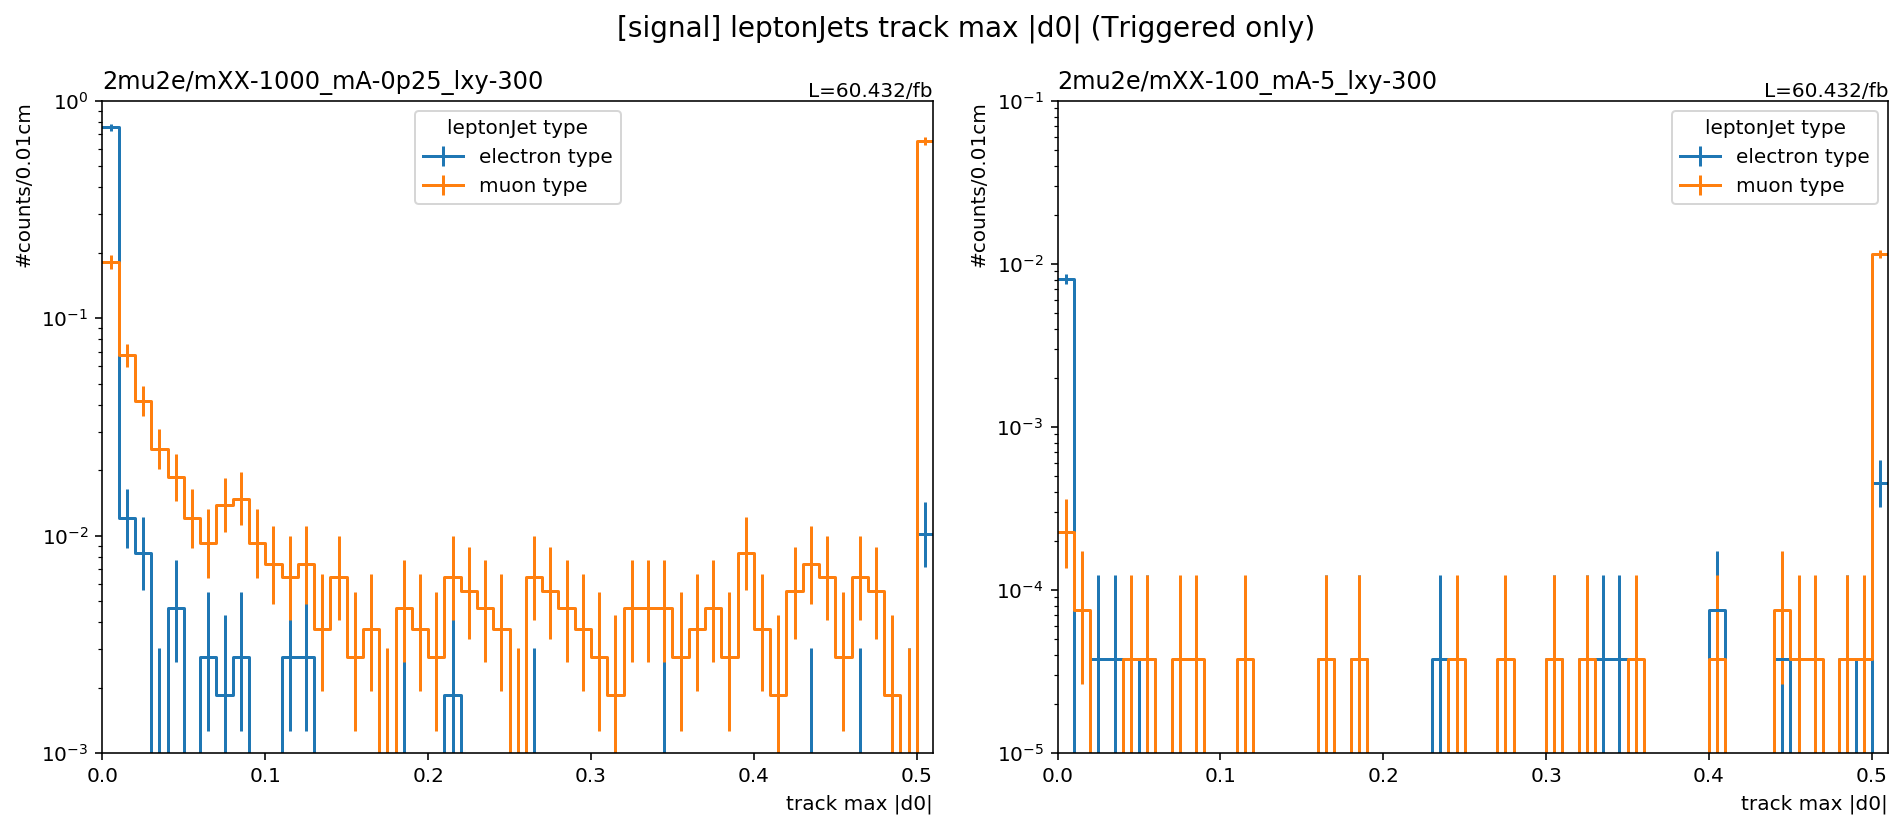

In [10]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['maxd0'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
axes[0, 0].set_ylim([1e-3, 1e0])
axes[0, 1].set_ylim([1e-5, 1e-1])
plt.suptitle('[signal] leptonJets track max |d0| (Triggered only)', fontsize=14);

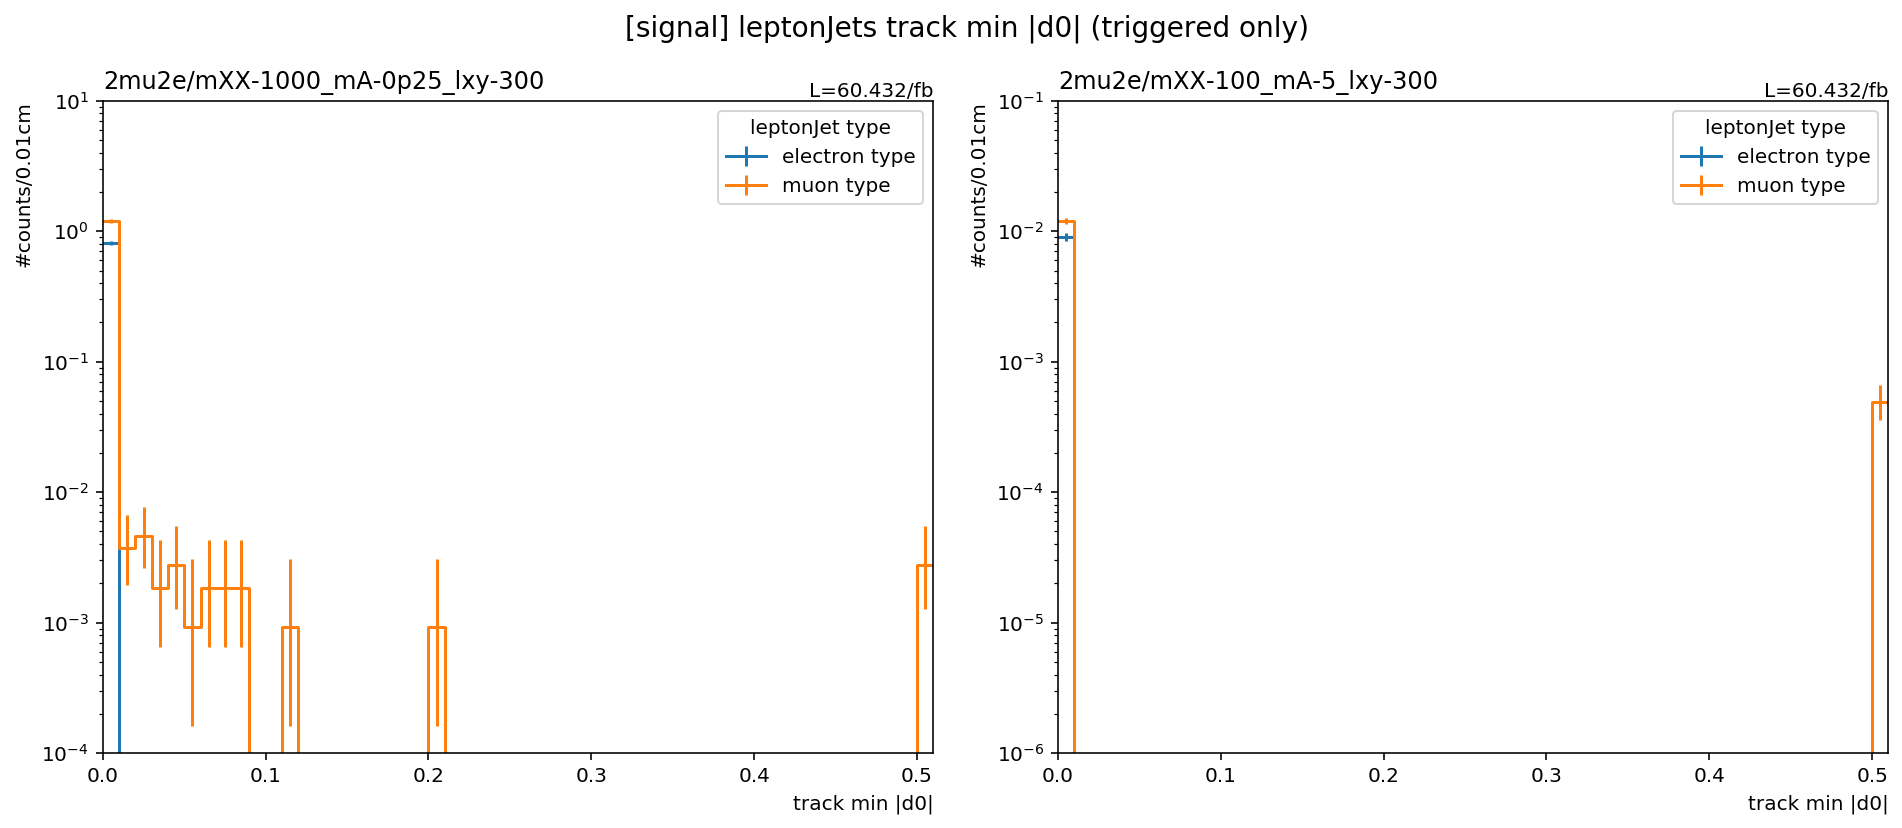

In [11]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['mind0'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e1])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
axes[0,1].set_ylim([1e-6, 1e-1])
plt.suptitle('[signal] leptonJets track min |d0| (triggered only)', fontsize=14);

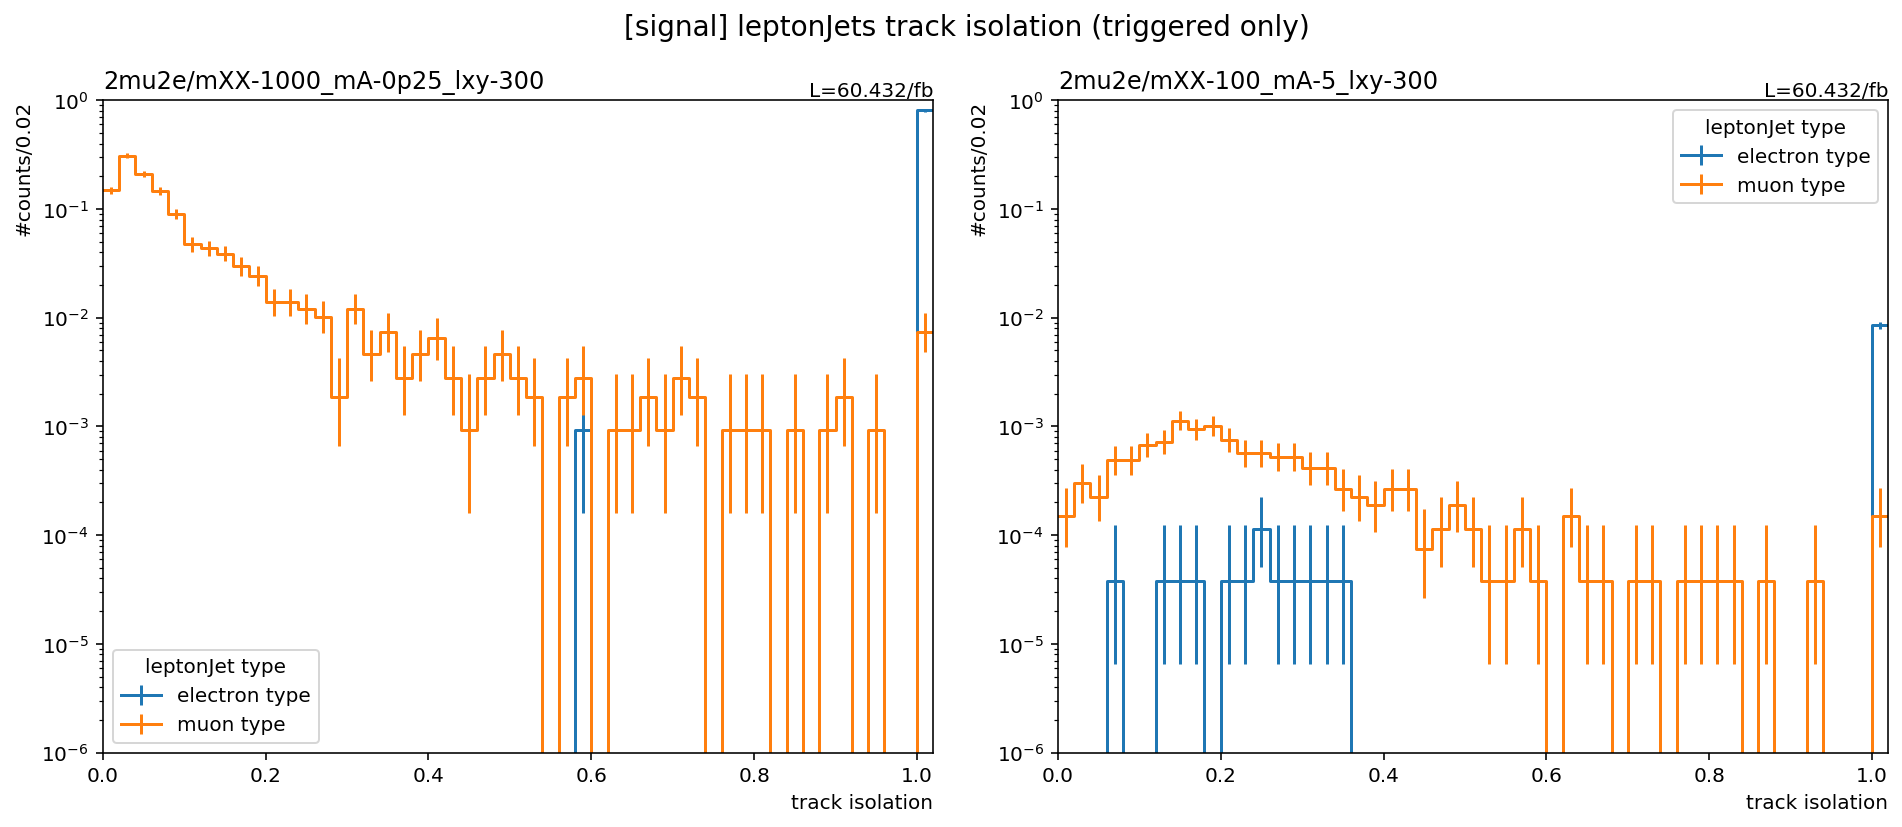

In [12]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['tkiso'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_ylim([1e-6, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
plt.suptitle('[signal] leptonJets track isolation (triggered only)', fontsize=14);

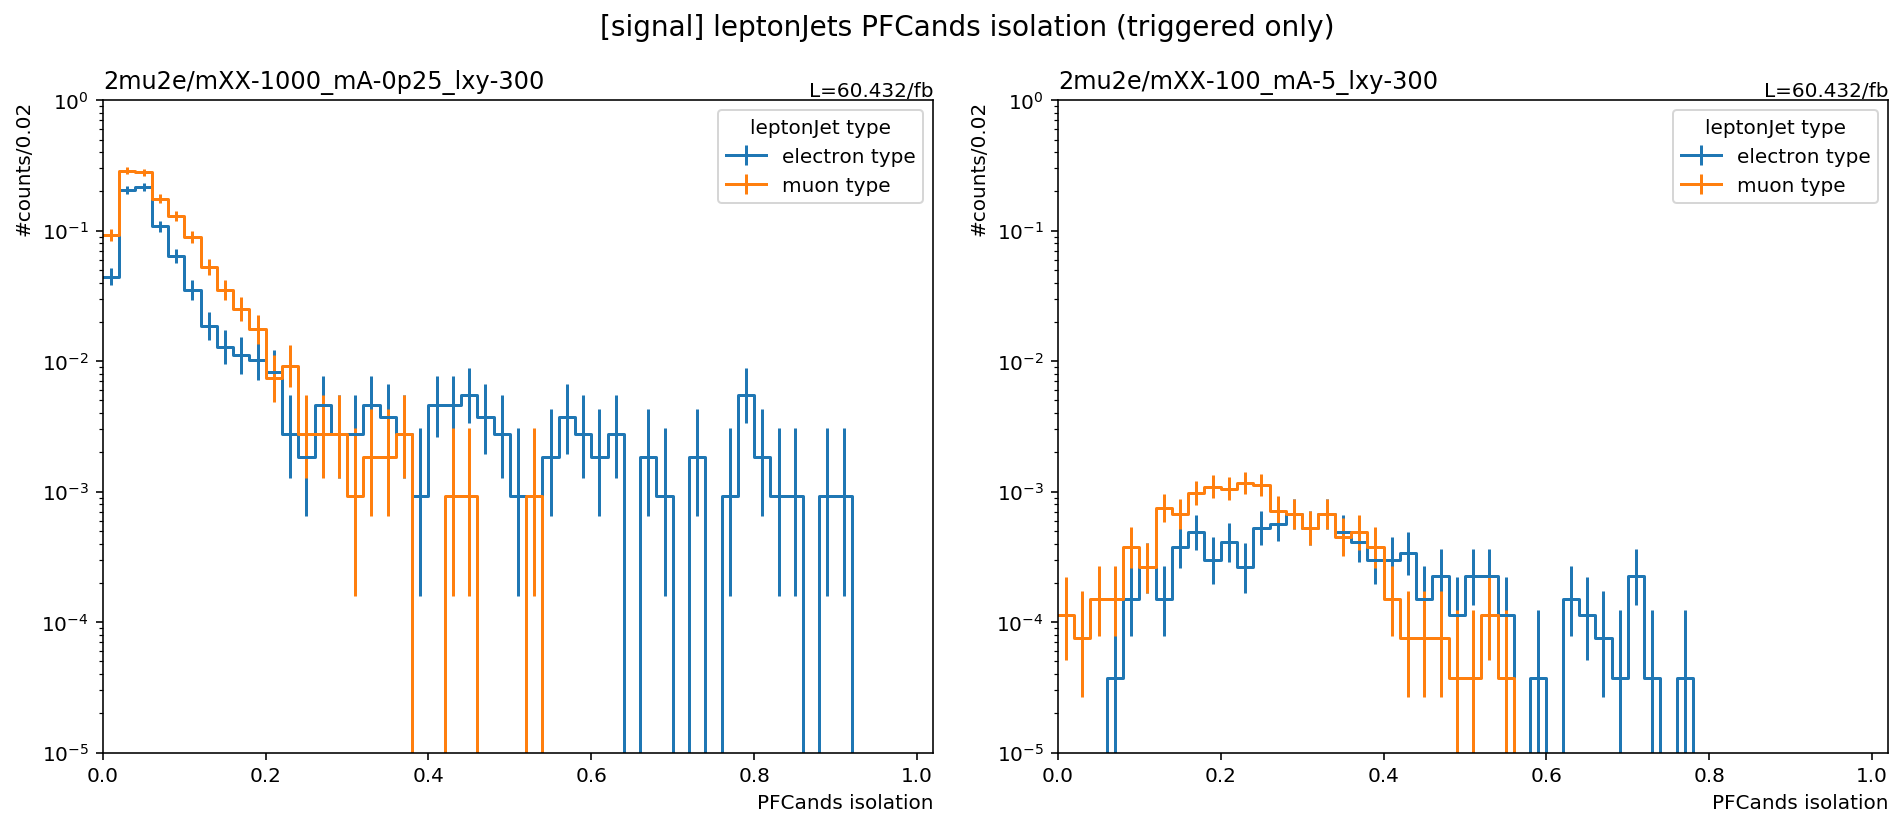

In [13]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['pfiso'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
plt.suptitle('[signal] leptonJets PFCands isolation (triggered only)', fontsize=14);

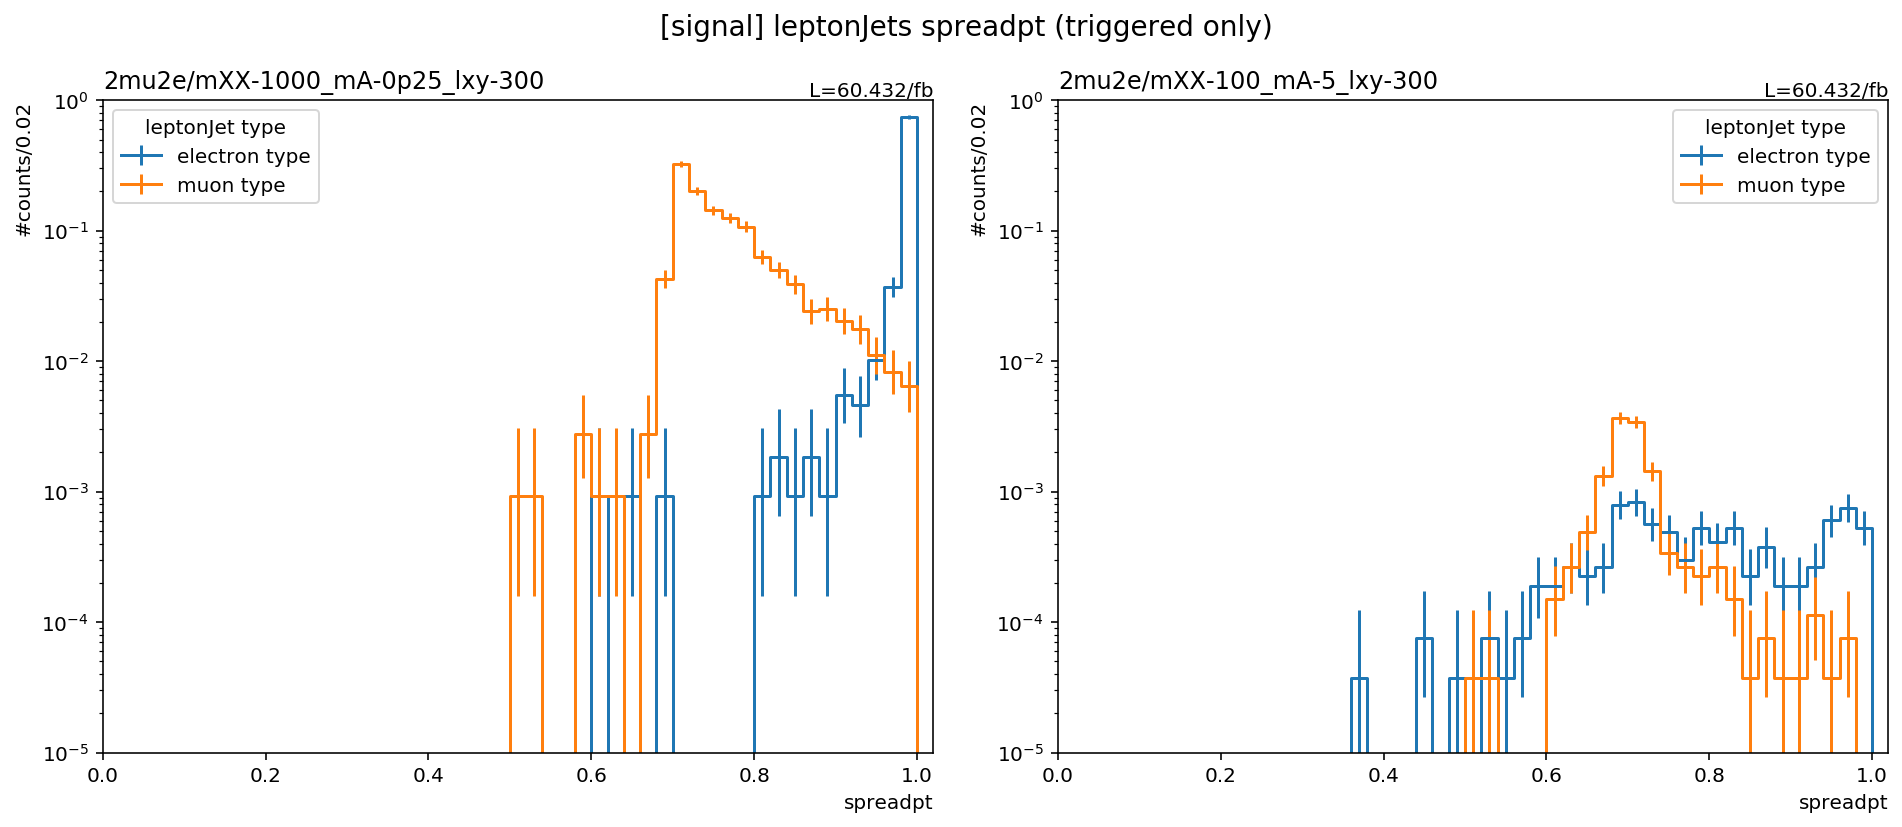

In [14]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['spreadpt'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
plt.suptitle('[signal] leptonJets spreadpt (triggered only)', fontsize=14);

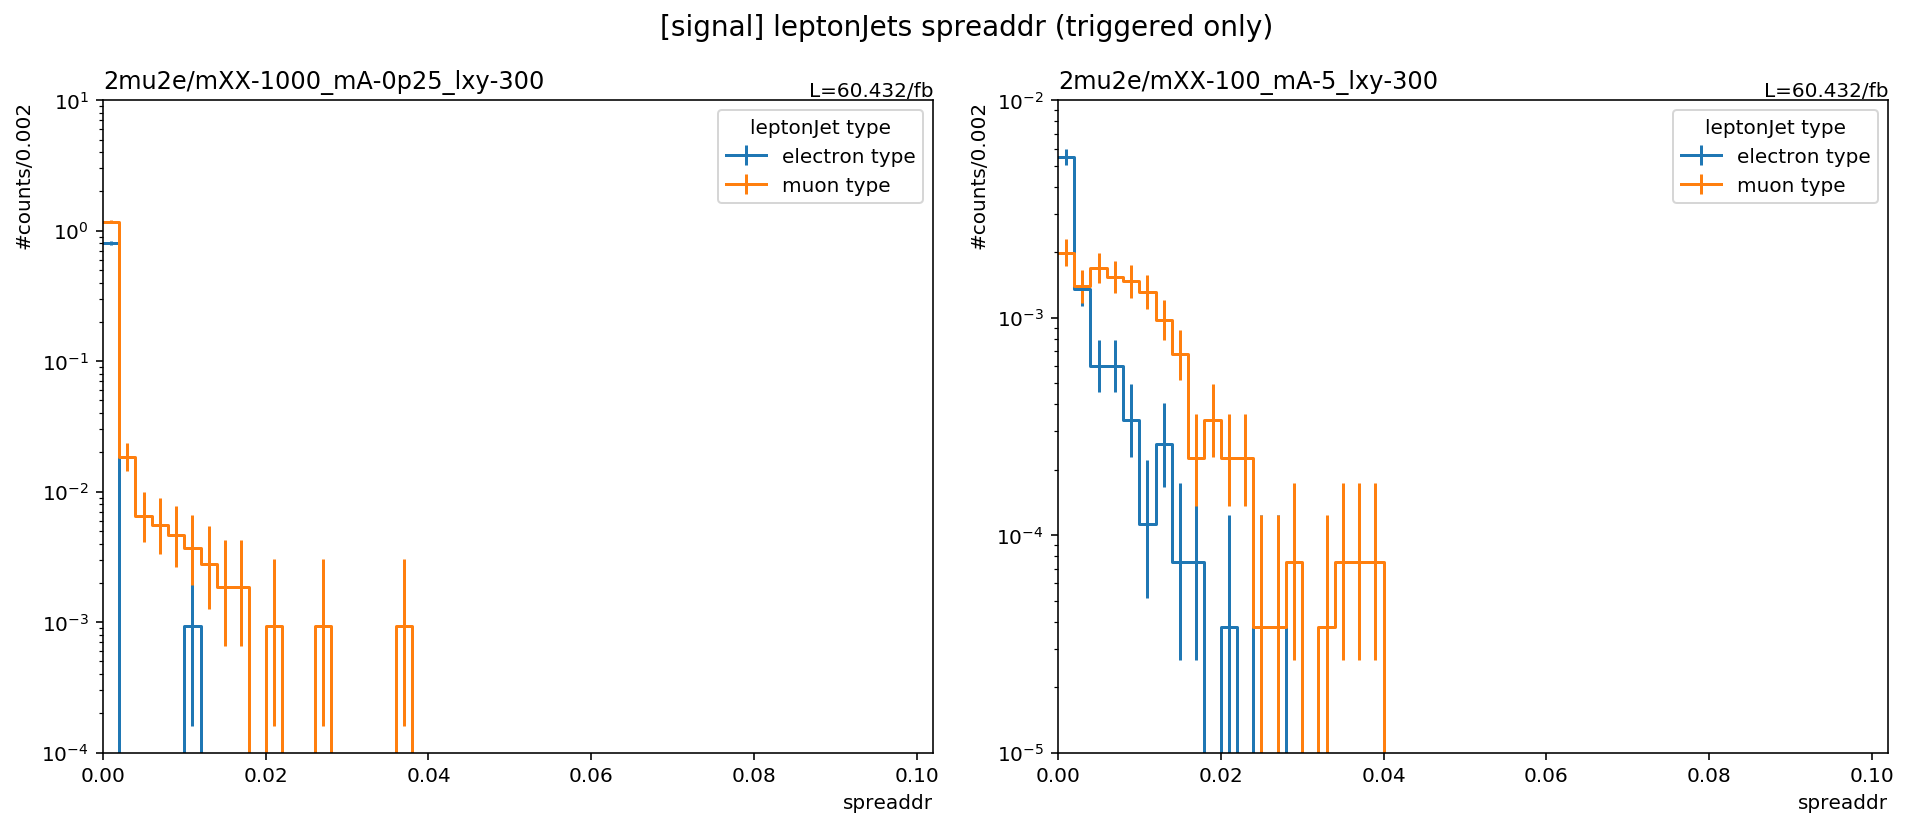

In [15]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['spreaddr'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e1])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
axes[0,1].set_ylim([1e-5, 1e-2])
plt.suptitle('[signal] leptonJets spreaddr (triggered only)', fontsize=14);

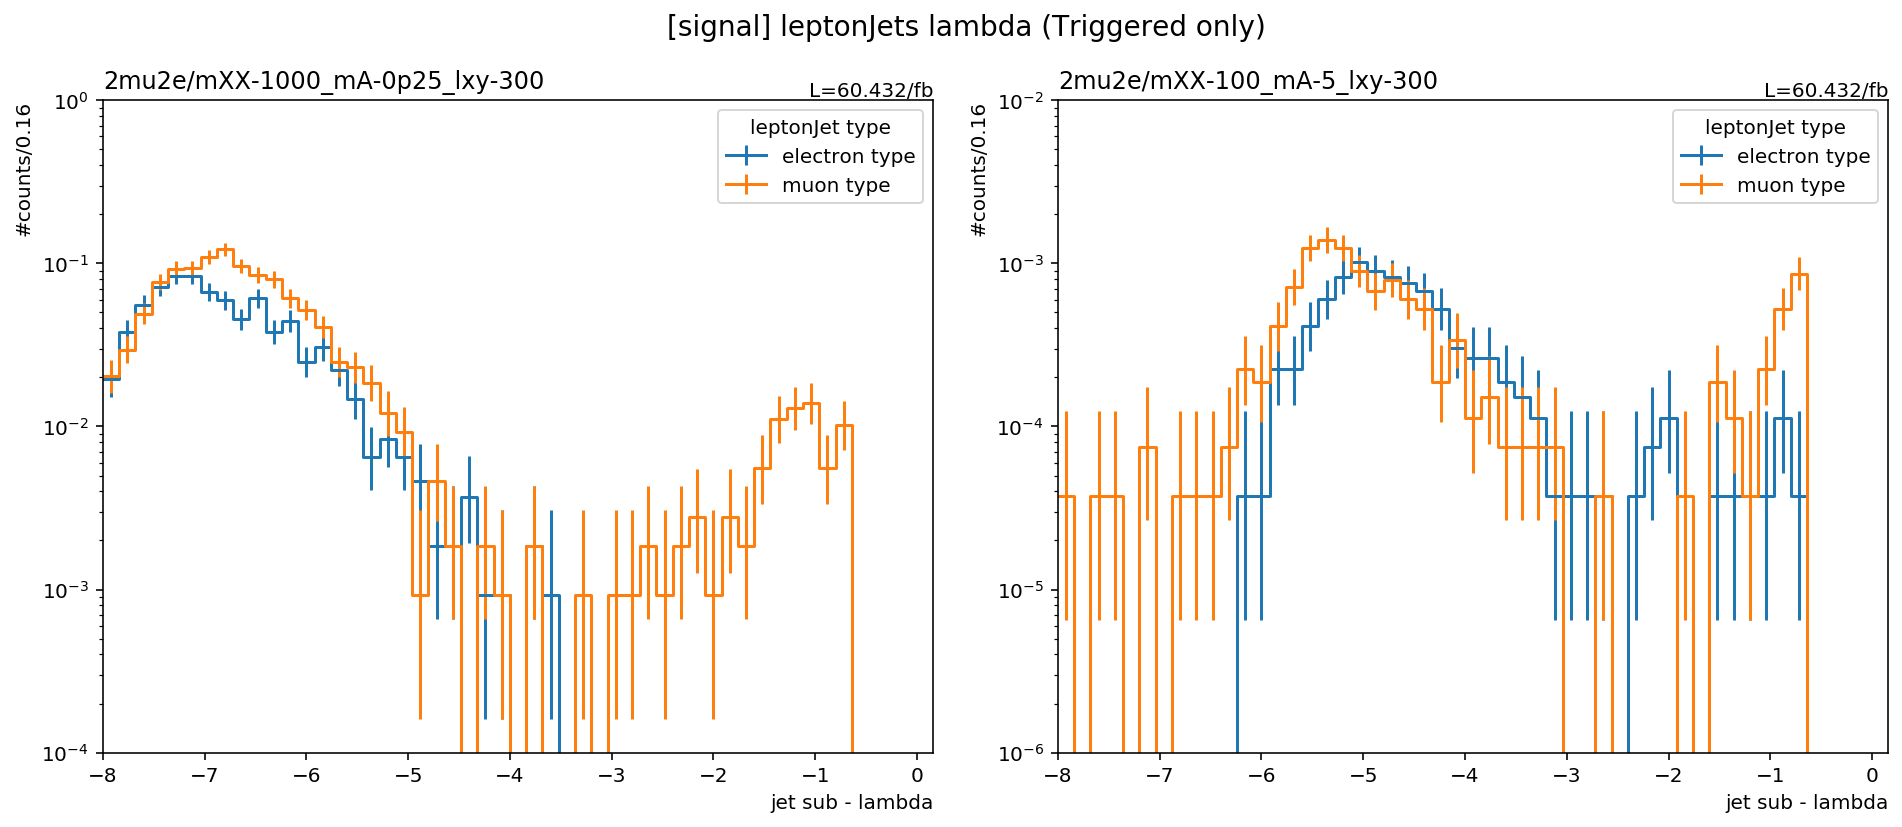

In [16]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['lamb'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
axes[0,1].set_ylim([1e-6, 1e-2])
plt.suptitle('[signal] leptonJets lambda (Triggered only)', fontsize=14);

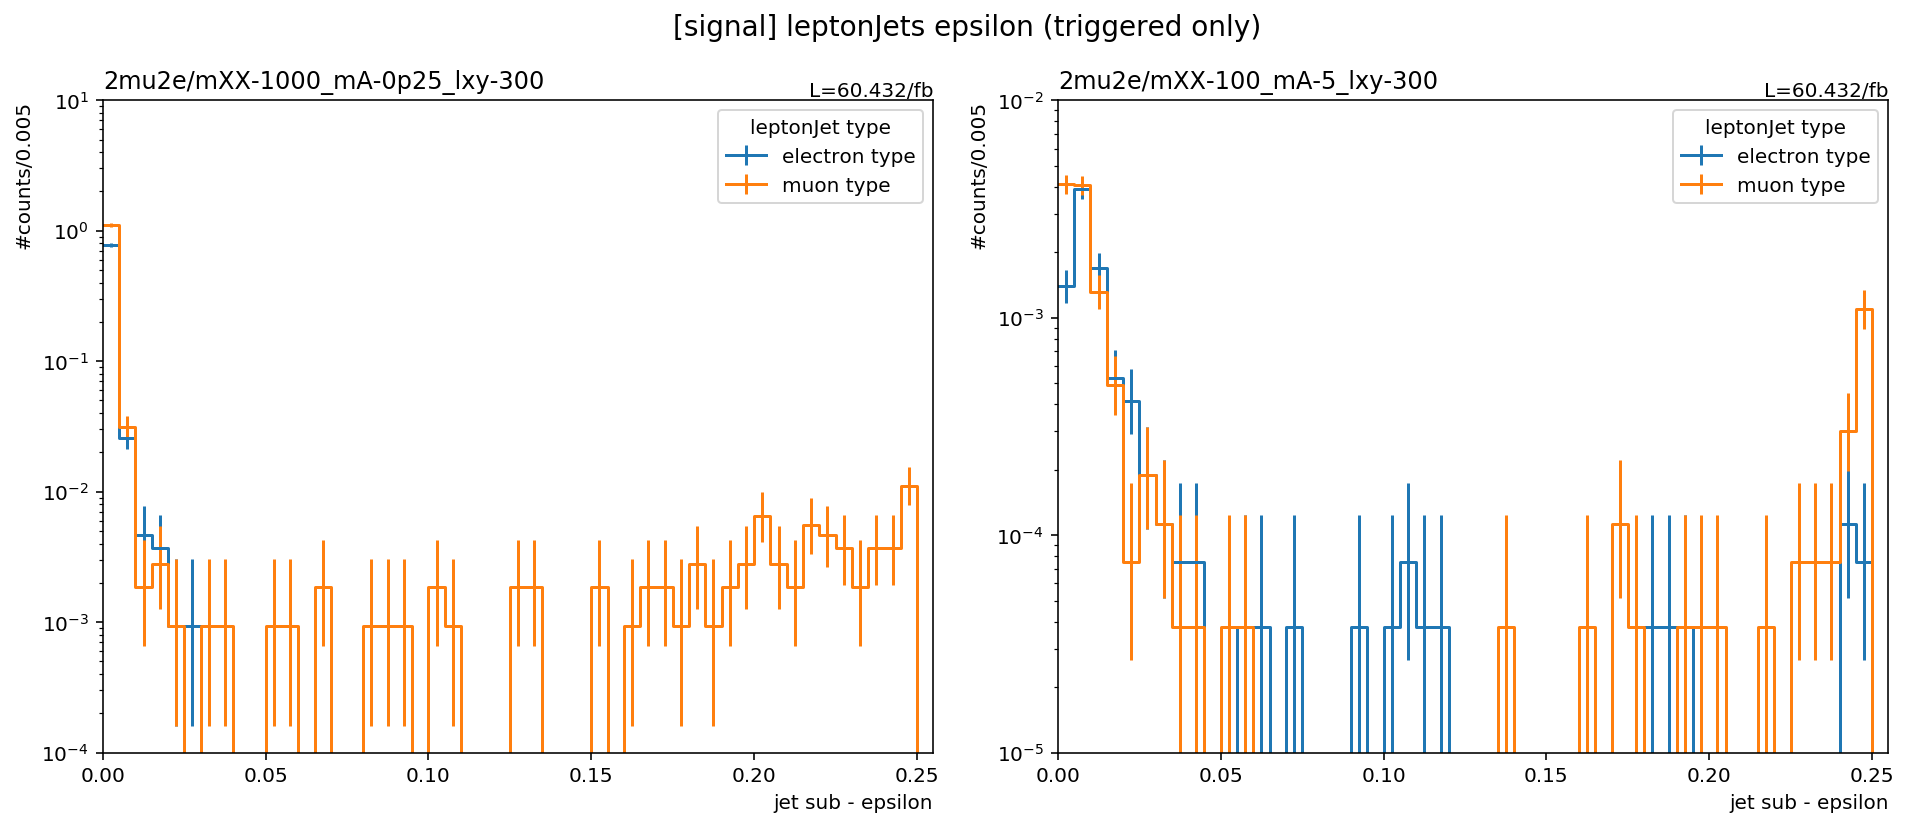

In [17]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['epsi'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e1])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
axes[0,1].set_ylim([1e-5, 1e-2])
plt.suptitle('[signal] leptonJets epsilon (triggered only)', fontsize=14);

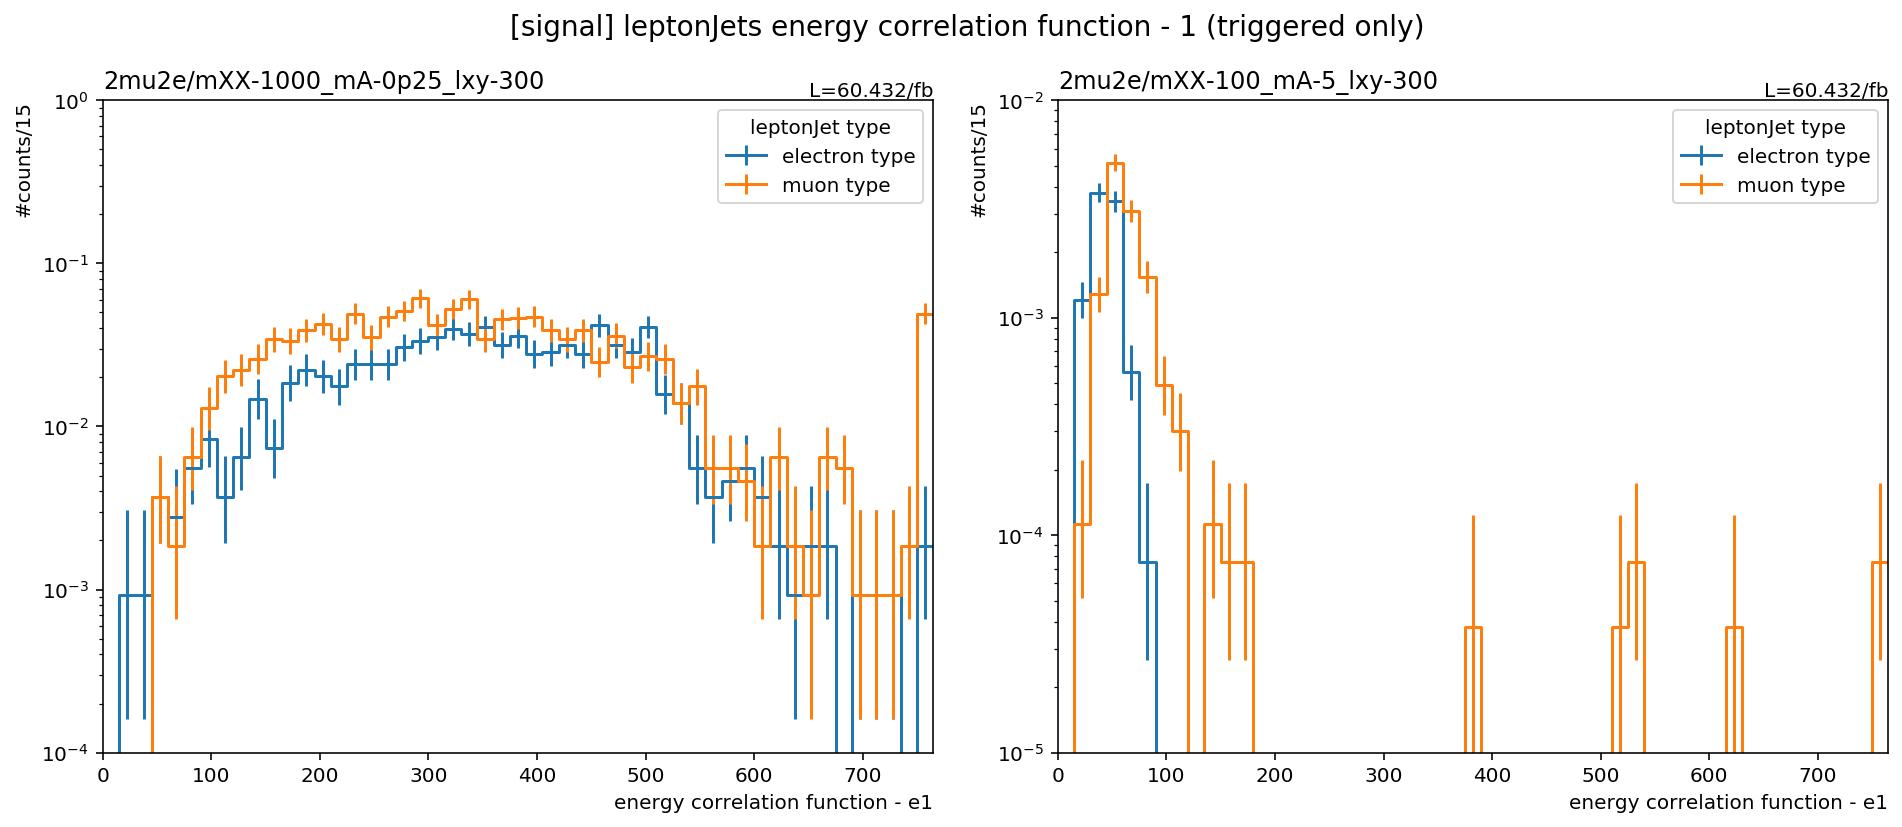

In [18]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['ecfe1'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
axes[0,1].set_ylim([1e-5, 1e-2])
plt.suptitle('[signal] leptonJets energy correlation function - 1 (triggered only)', fontsize=14);

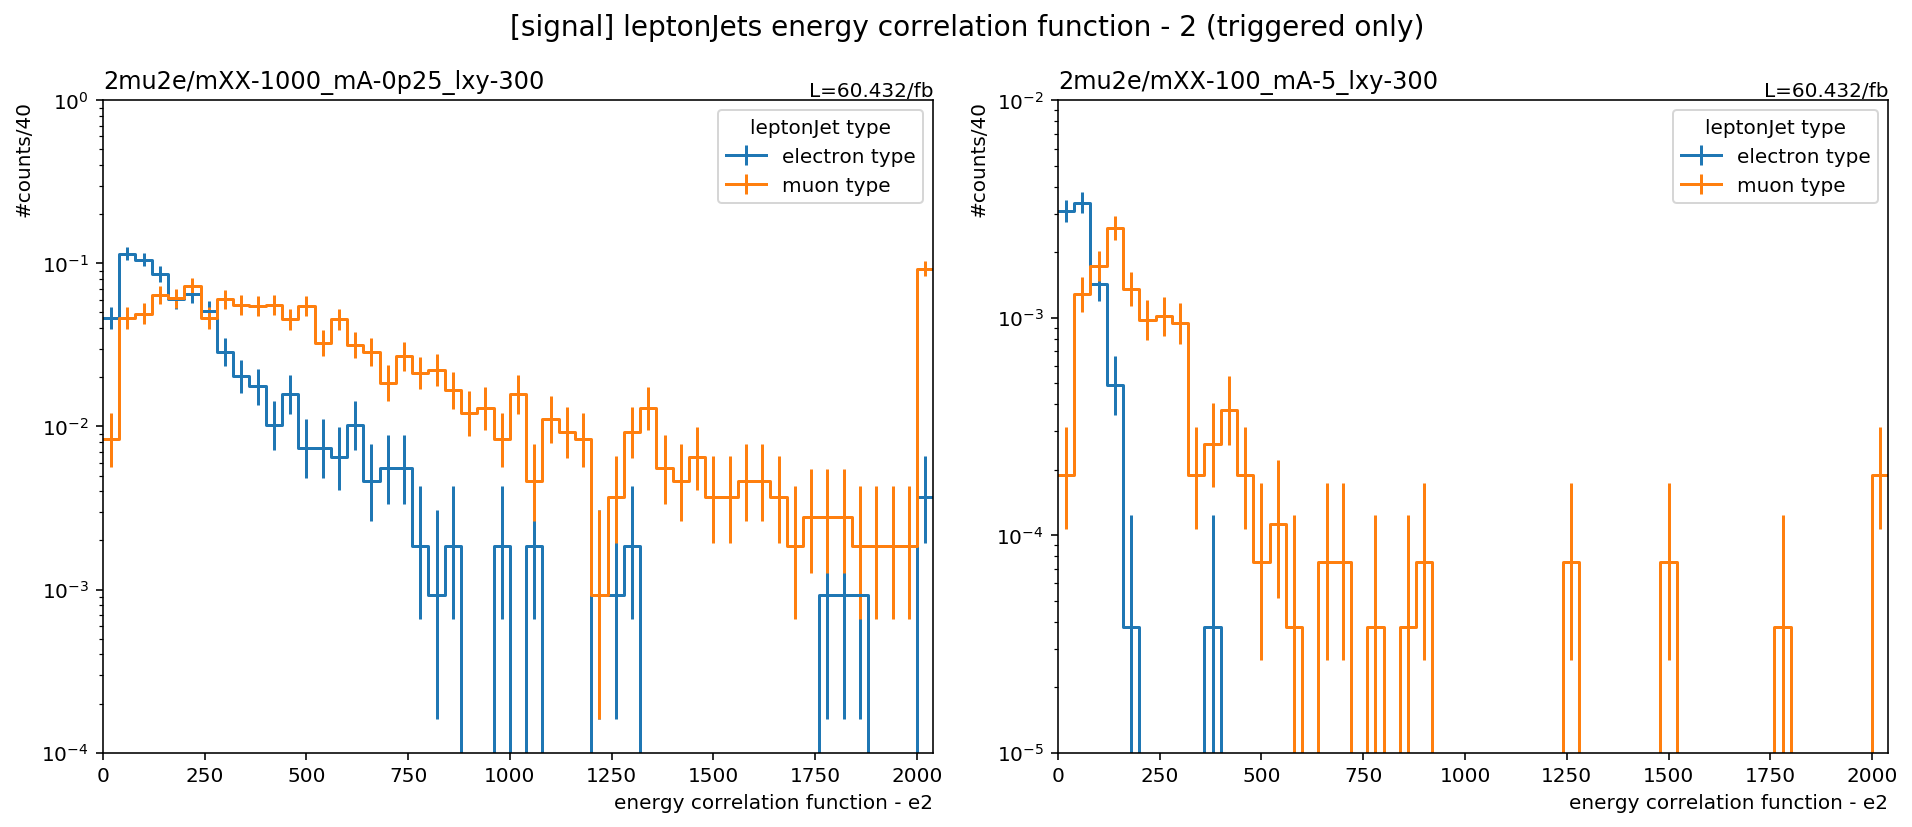

In [19]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['ecfe2'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
axes[0,1].set_ylim([1e-5, 1e-2])
plt.suptitle('[signal] leptonJets energy correlation function - 2 (triggered only)', fontsize=14);

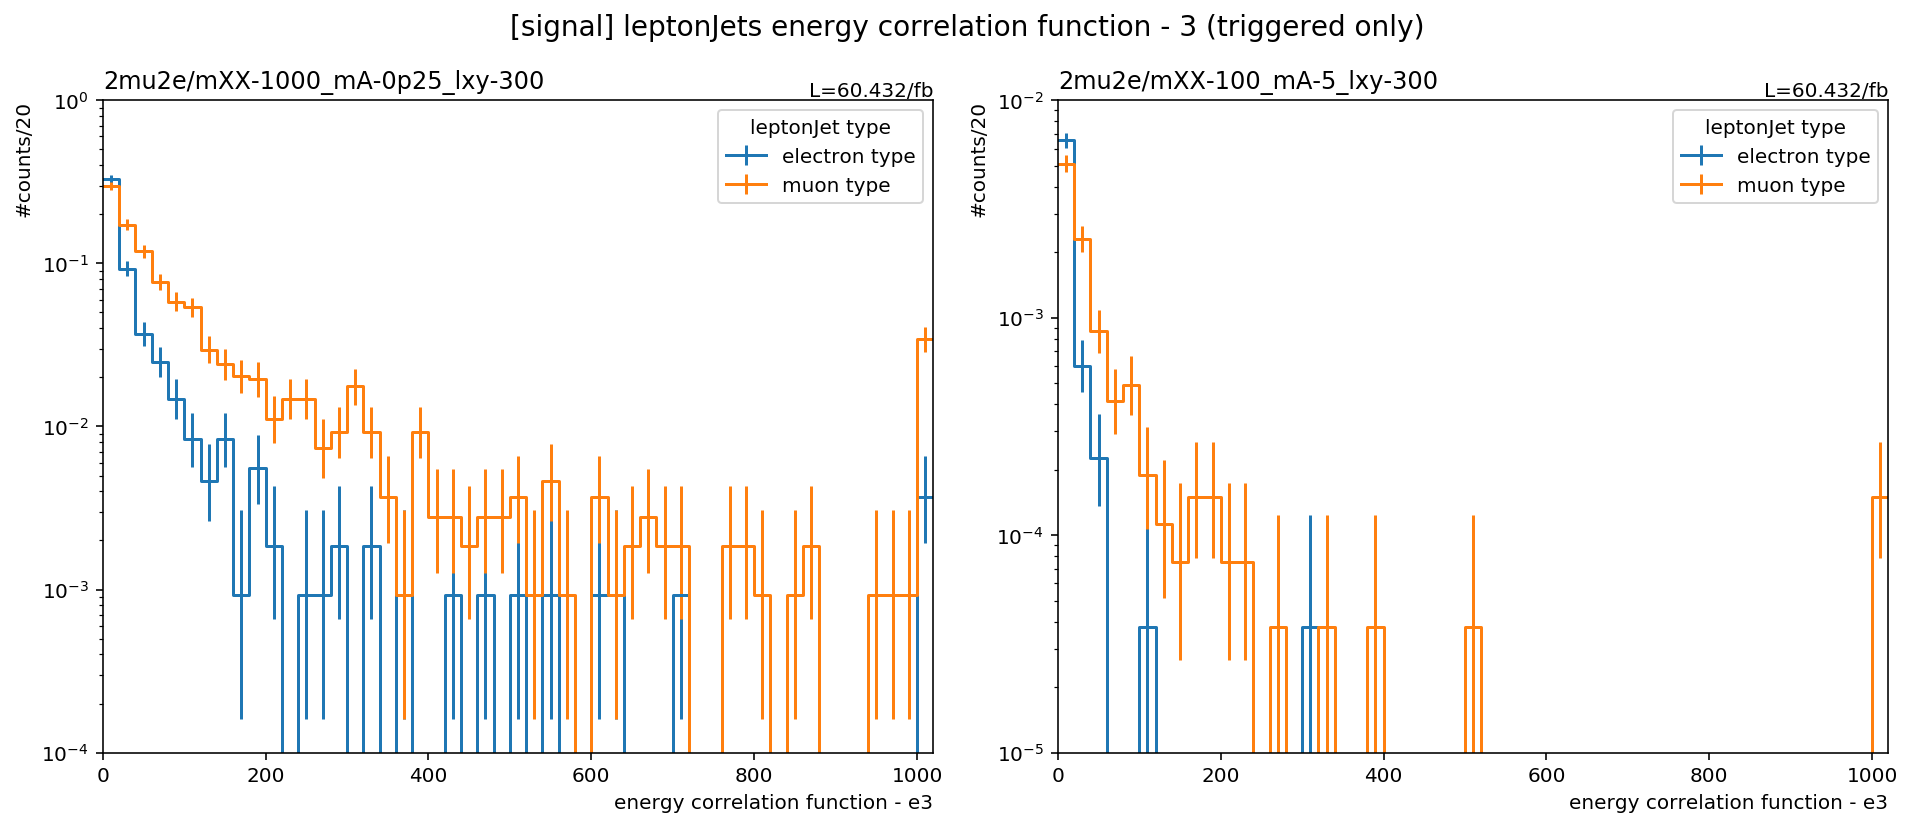

In [20]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['ecfe3'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
axes[0,1].set_ylim([1e-5, 1e-2])
plt.suptitle('[signal] leptonJets energy correlation function - 3 (triggered only)', fontsize=14);

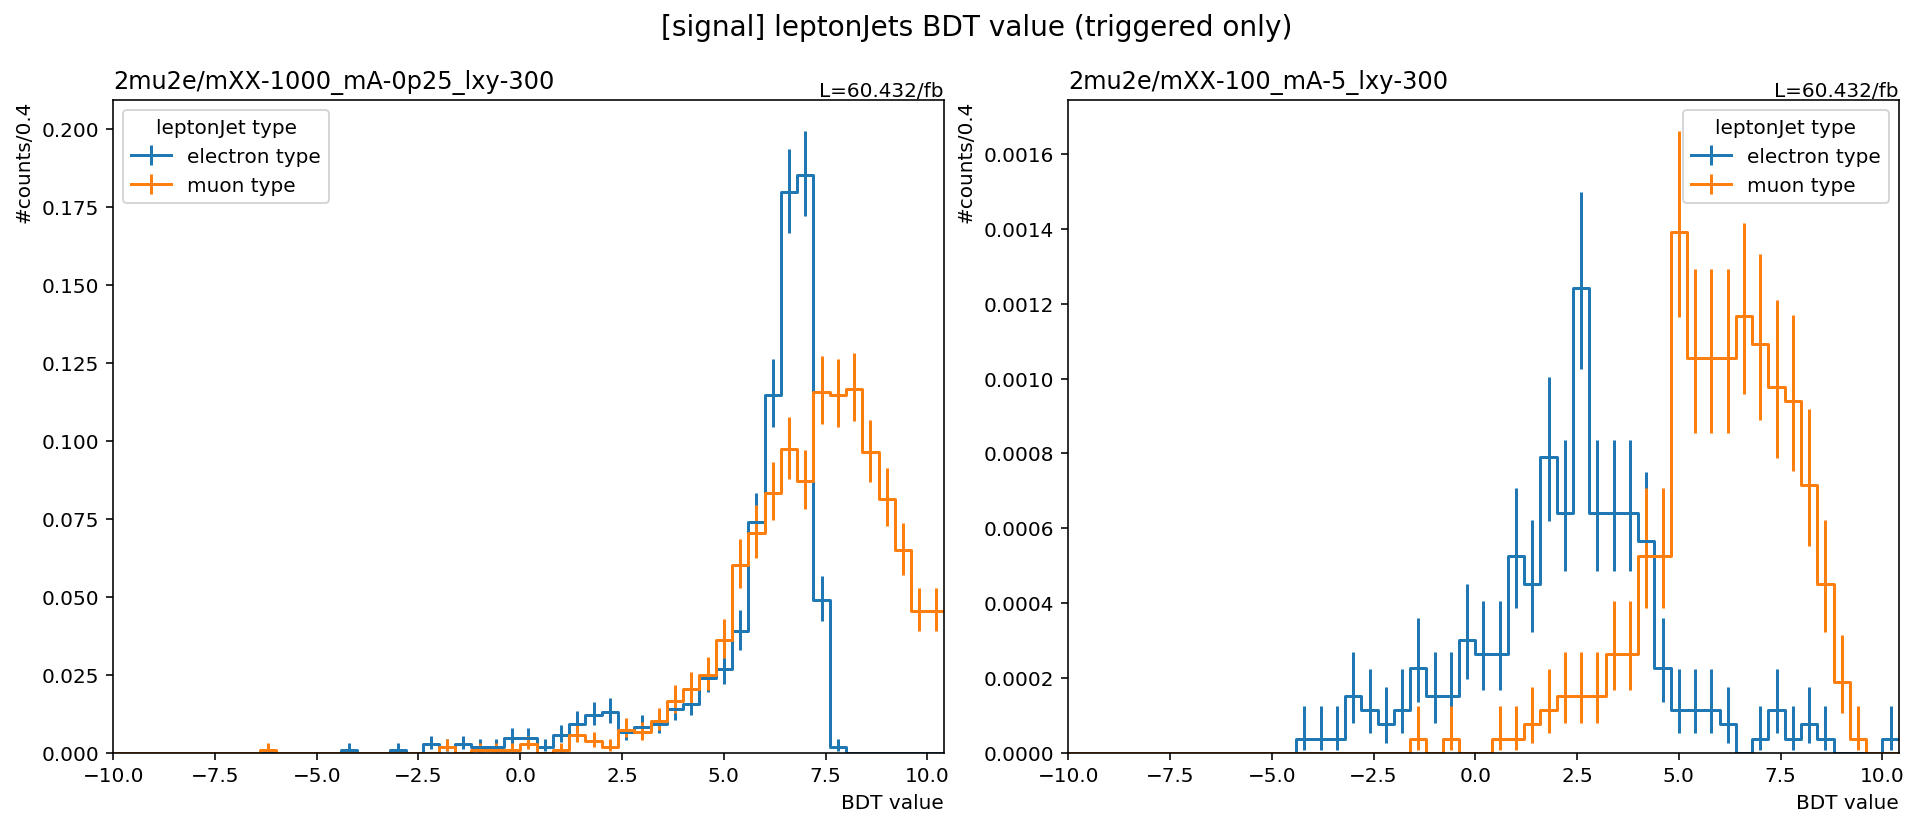

In [21]:
fig, _ = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.15})
fig, axes = hist.plotgrid(output['mva'], figure=fig, col='dataset', overlay='typed', overflow='over', density=False)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(ax.get_title(), x=0.0, ha='left')
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')
plt.suptitle('[signal] leptonJets BDT value (triggered only)', fontsize=14);